## Exploratory Analyses

### Imports

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from itertools import chain
import pingouin as pg
import random

### Load data

In [65]:
# get puzzle ratings:
puzzles = pd.read_csv("../data/puzzle_ratings_Dec15.csv")
# puzzles["date"] = puzzles["date"].apply(pd.Timestamp)

# get rapid ratings:
ratings = pd.read_csv("../data/rapid_ratings_Dec15.csv")
#ratings["date"] = ratings["date"].apply(pd.Timestamp).reset_index(drop=True, inplace=True)

# get rapid games:
rapid_games = pd.read_csv("../data/rapid_games_Dec15final.csv")
mapping = {
    "username": "category",
    "id": "string",
    "rated": "boolean",
    "status": "category",
    "winner": "category",
    "outcome": "category",
}
rapid_games = rapid_games.astype(mapping)

# convert date strings to date time:
rapid_games["createdAt"] = rapid_games["createdAt"].apply(pd.Timestamp)
rapid_games["lastMoveAt"] = rapid_games["lastMoveAt"].apply(pd.Timestamp)

# convert list strings to lists:
rapid_games["LAN"] = rapid_games["LAN"].apply(ast.literal_eval)
rapid_games["evaluation"] = rapid_games["evaluation"].apply(ast.literal_eval)
rapid_games["cp_losses"] = rapid_games["cp_losses"].apply(ast.literal_eval)
rapid_games["moveTimes"] = rapid_games["moveTimes"].apply(ast.literal_eval)
rapid_games["dateCreated"] = rapid_games["createdAt"].apply(lambda x: x.to_pydatetime().date())

rapid_games.info() #.astype(mapping)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35593 entries, 0 to 35592
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   username          35593 non-null  category           
 1   id                35593 non-null  string             
 2   rated             35593 non-null  boolean            
 3   speed             35593 non-null  object             
 4   createdAt         35593 non-null  datetime64[ns, UTC]
 5   lastMoveAt        35593 non-null  datetime64[ns, UTC]
 6   status            35593 non-null  category           
 7   winner            33990 non-null  category           
 8   opening           35593 non-null  object             
 9   moves             35593 non-null  object             
 10  clocks            35593 non-null  object             
 11  clock             35593 non-null  object             
 12  analysis          35593 non-null  object             
 13  w

In [39]:
latest_date = puzzles["date"].max()
puzzles = puzzles[puzzles["date"] > pd.Timestamp(year=latest_date.year, month=latest_date.month - 6, day=latest_date.day)]

latest_date = ratings["date"].max()
ratings = ratings[ratings["date"] > pd.Timestamp(year=latest_date.year, month=latest_date.month - 6, day=latest_date.day)]

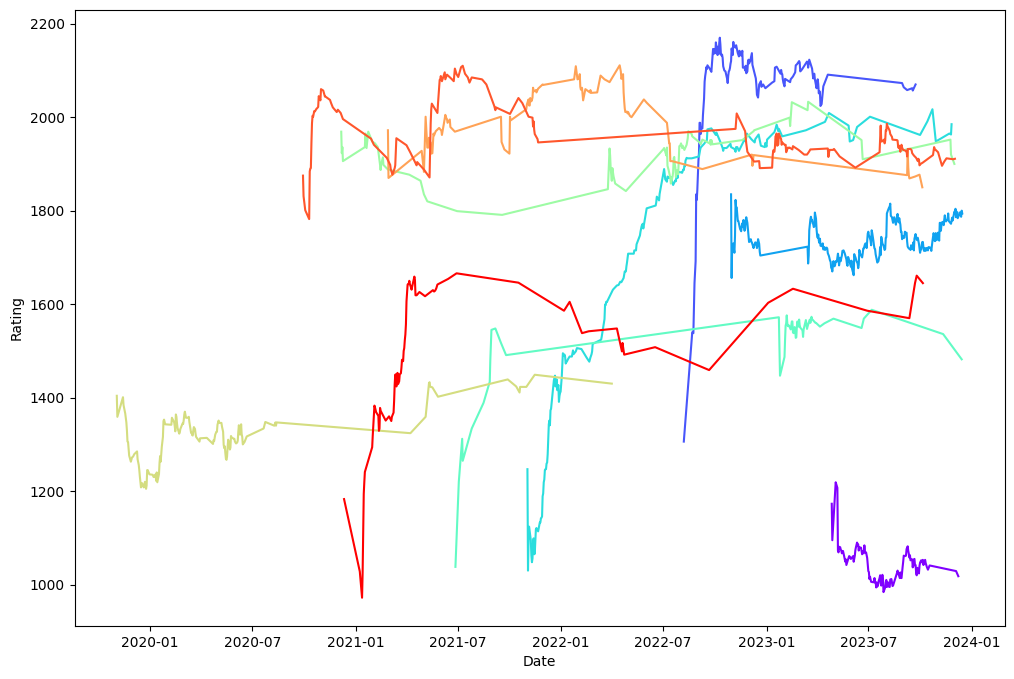

In [99]:
import pandas as pd
import matplotlib.pyplot as plt

ratings["date"] = ratings["date"].apply(pd.Timestamp)
users = random.sample(list(ratings.username.unique()), k=10)
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(users))))

plt.figure(figsize=(12, 8))

for i, user in enumerate(users):
    # subset data by user:
    subset = ratings[ratings['username'] == user]
    # sort ratings by date:
    subset = subset.sort_values(by='date')
    plt.plot(subset['date'], subset['rating'], linestyle='-', color=next(color), label=user)

plt.xlabel('Date')
plt.ylabel('Rating')
plt.show()

In [76]:
import random
users = random.sample(list(ratings.username.unique()), k=20)
users

['RDVisual',
 'EnzoChess2008',
 'kceniy1977',
 'Edwardslay',
 'manulo5',
 'Cpalmerov',
 'Lvinicios777',
 'Mr_Jhon_XX24578',
 'ZShep07',
 'getthat',
 'Tornado32',
 'couchGuy',
 'email_chess',
 'neljapachi',
 'wayside',
 'Mauriciodaher',
 'Frosty_Grim',
 'lucastro',
 'julmarpuyaters',
 'Iagoborgespr']

## Thinking time Distributions

Caveats: 
- There are a lot of different time formats in the data. By far the most common is 10+0
- only values > 0 included, since log(0)=-Inf gives an error for the histogram -> no **premoves**

In [40]:
game_formats = pd.DataFrame(rapid_games["clock"].value_counts().keys())
game_formats["timeFormat"] = game_formats["clock"].apply(ast.literal_eval)
game_formats = pd.DataFrame(game_formats["timeFormat"].to_list())
game_formats["initial"] = (game_formats["initial"]/60).astype("int")
game_formats["frequency"] = rapid_games["clock"].value_counts().values
game_formats.drop(columns="totalTime")

,initial,increment,frequency
0,10,0,29149
1,10,5,3673
2,15,10,1027
3,5,5,288
4,7,3,175
...,...,...,...
133,9,2,1
134,3,13,1
135,16,10,1
136,8,25,1


In [41]:
all_move_times = list(chain.from_iterable(rapid_games["moveTimes"].to_list()))
all_move_times = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

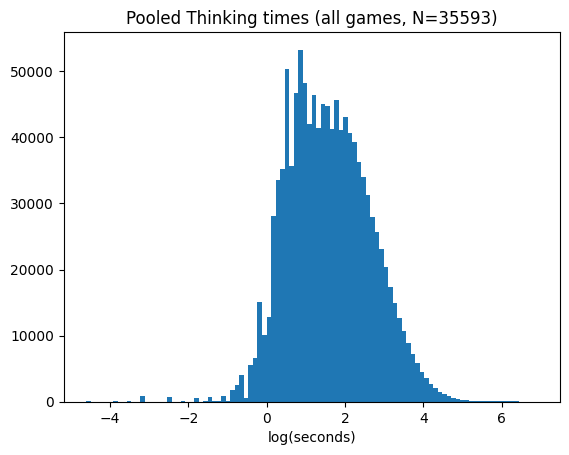

In [42]:
plt.hist(all_move_times, bins=100)
plt.title(f"Pooled Thinking times (all games, N={len(rapid_games)})")
plt.xlabel("log(seconds)")

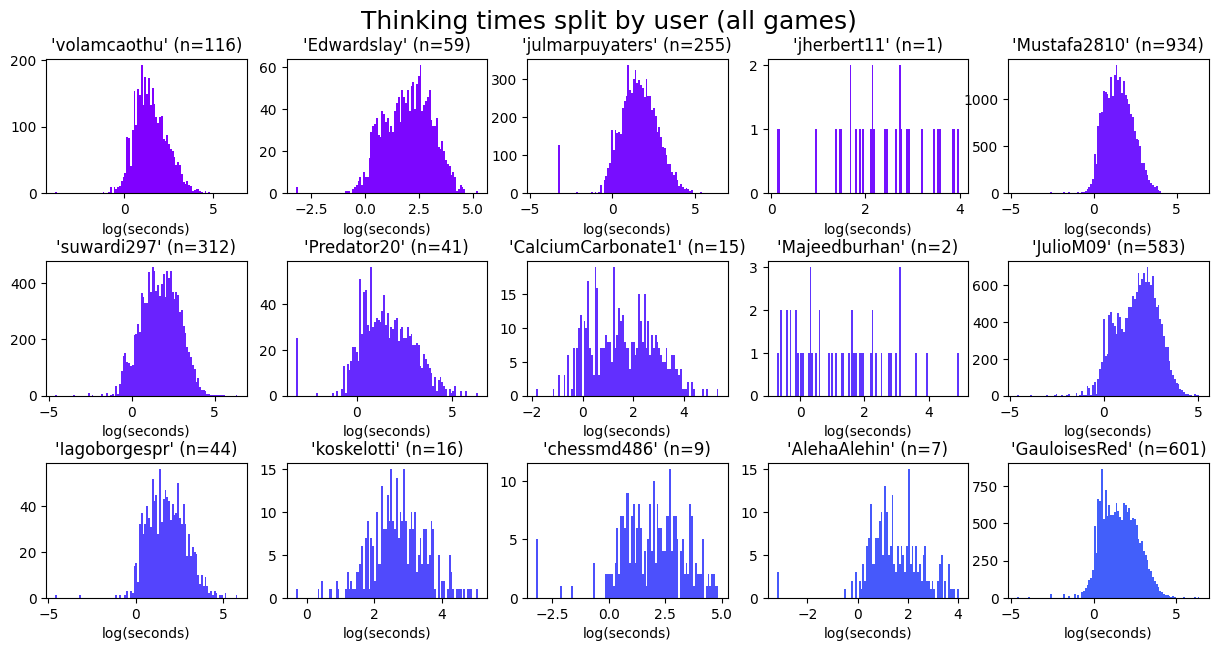

In [43]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (all games)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(rapid_games.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    by_user = rapid_games[rapid_games["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=100, color=next(color))
    ax.set_title(f"'{user}' (n={len(rapid_games[rapid_games["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()


#### Filtered for Games **with** Increment

In [44]:
with_increment = rapid_games[rapid_games["increment"] != 0]

In [45]:
move_times_increment = list(chain.from_iterable(with_increment["moveTimes"].to_list()))
move_times_increment = np.log([x for x in all_move_times if x > 0])

Text(0.5, 0, 'log(seconds)')

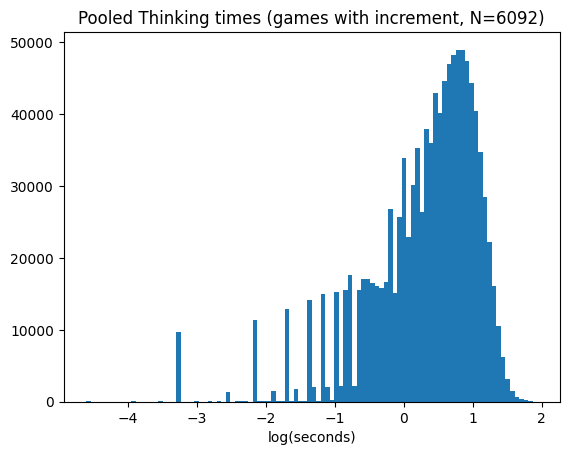

In [46]:
plt.hist(move_times_increment, bins=100)
plt.title(f"Pooled Thinking times (games with increment, N={len(with_increment)})")
plt.xlabel("log(seconds)")

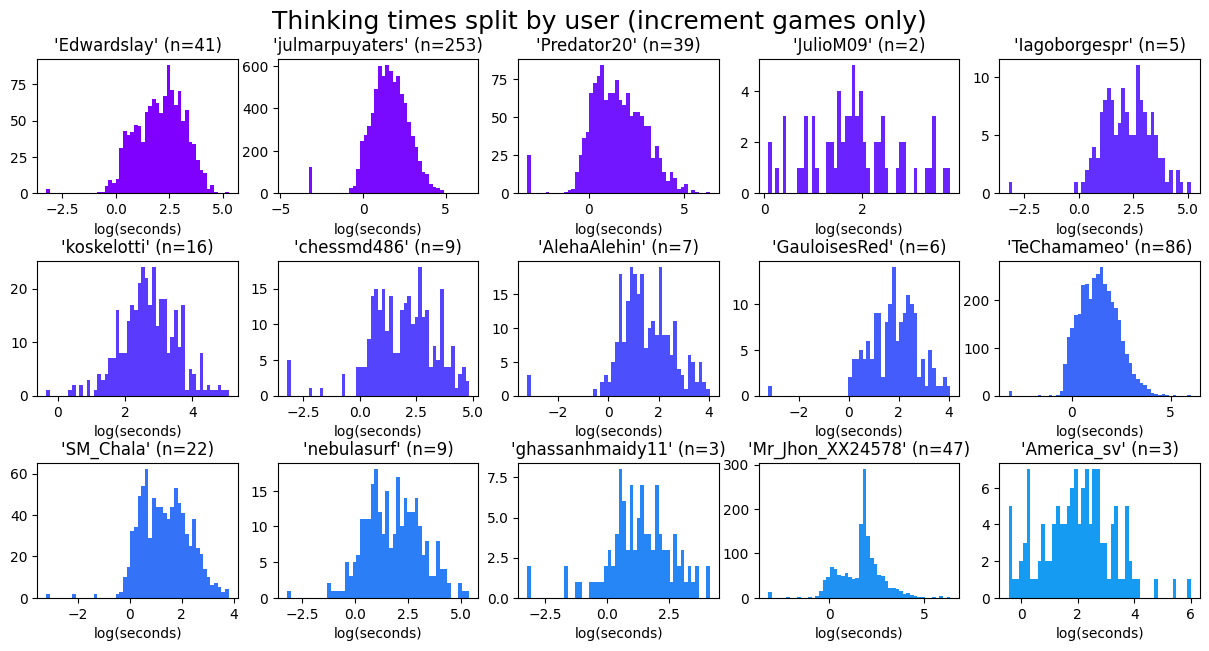

In [47]:
# Create a 5x3 grid of subplots
fig, axs = plt.subplots(3, 5, figsize=(15, 7))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Thinking times split by user (increment games only)", fontsize=18, y=0.95)

# Create a color iterator
color = iter(plt.cm.rainbow(np.linspace(0, 1, len(with_increment.username.unique()))))

# Iterate over unique usernames and corresponding subplots
for user, ax in zip(with_increment.username.unique(), axs.ravel()):
    by_user = with_increment[with_increment["username"]==user]
    think_times = list(chain.from_iterable(by_user["moveTimes"].to_list()))
    think_times = np.log([x for x in think_times if x > 0])
    
    # Plot the histogram on the specified subplot
    ax.hist(think_times, bins=50, color=next(color))
    ax.set_title(f"'{user}' (n={len(with_increment[with_increment["username"]==user])})")
    ax.set_xlabel("log(seconds)")

# Show the plots
plt.show()

## Activity per user

In [51]:
for i in range(len(rapid_games)):
    for j in range(len(ratings)):
        if rapid_games.loc[i,"dateCreated"] == ratings.loc[j, "date"] and rapid_games.loc[i,"username"] == ratings.loc[j, "username"]:
            rapid_games.loc[i, "ratingOnDay"] = ratings.loc[j,"rating"]

In [52]:
# Define the mapping
outcome_mapping = {"win": 1, "draw": 0.5, "loss": 0}

# Apply the mapping to create a new numeric column
rapid_games["outcome_numeric"] = rapid_games["outcome"].map(outcome_mapping).astype("float")

In [ ]:
from matplotlib.dates import DateFormatter
from matplotlib.ticker import MaxNLocator

fig, axs = plt.subplots(5, 3, figsize=(15, 20))
plt.subplots_adjust(hspace=0.5)
plt.suptitle("Winrates (color) per day", fontsize=18, y=0.95)
plt.title("size indicates number of games played, color indicates win percentage.", fontsize=10, y=1)
for user, ax in zip(rapid_games.username.unique(), axs.ravel()):
    games_by_user = rapid_games[rapid_games["username"]==user].groupby("dateCreated")
    percentage_won = games_by_user["outcome_numeric"].mean()
    ax.scatter(
        games_by_user["ratingOnDay"].count().index, 
        games_by_user["ratingOnDay"].mean(), 
        edgecolor='black', 
        linewidth=0.3,
        s=4 + games_by_user["ratingOnDay"].count()*4, 
        c=percentage_won,  # Use percentage of games won for color
        cmap='RdYlGn',   # Choose a colormap
        alpha=1,
    ) 
    ax.set_title(f"'{user}'")
    ax.set_xlabel("month/year")
    ax.set_ylabel("ELO")
    desired_number_of_ticks=5
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=desired_number_of_ticks))
    myFmt = DateFormatter("%m/%y")
    ax.xaxis.set_major_formatter(myFmt)
    #ax.title(f"Games over time for '{user}'")

# Show the plots

plt.show()


## Correlations

### Correlations (all data)

In [ ]:
cor_columns = set(rapid_games.columns)
cor_columns.remove("rated")
cor_columns.remove("increment")

cor_matrix = round(rapid_games[["blunders","averaged_cp_loss","ratingOnDay"]].corr(numeric_only=True), 2)
cor_matrix

### Correlations (averaged for each user)

In [55]:
rapid_games["analysed"] = rapid_games["analysis"].apply(lambda x: 0 if pd.isna(x) else 1)

In [58]:
averages = ratings.groupby("username").mean("rating")
averages["games_played"] = rapid_games.groupby("username", observed=False).count()["id"]
averages["games_analysed"] = rapid_games.groupby("username", observed=False)["analysed"].sum()
averages["avg_cp_loss/game"] = rapid_games.groupby("username", observed=False)["averaged_cp_loss"].mean()
averages["avg_blunders/game"] = rapid_games.groupby("username", observed=False)["blunders"].mean()
averages["puzzle_rating"] = puzzles.groupby("username", observed=False)["rating"].mean()

averages.corr().round(2)

,rating,games_played,games_analysed,avg_cp_loss/game,avg_blunders/game,puzzle_rating
rating,1.00,-0.04,-0.04,-0.64,-0.56,0.82
games_played,-0.04,1.00,1.00,0.15,0.15,-0.16
games_analysed,-0.04,1.00,1.00,0.15,0.15,-0.16
avg_cp_loss/game,-0.64,0.15,0.15,1.00,0.78,-0.56
avg_blunders/game,-0.56,0.15,0.15,0.78,1.00,-0.48
puzzle_rating,0.82,-0.16,-0.16,-0.56,-0.48,1.00


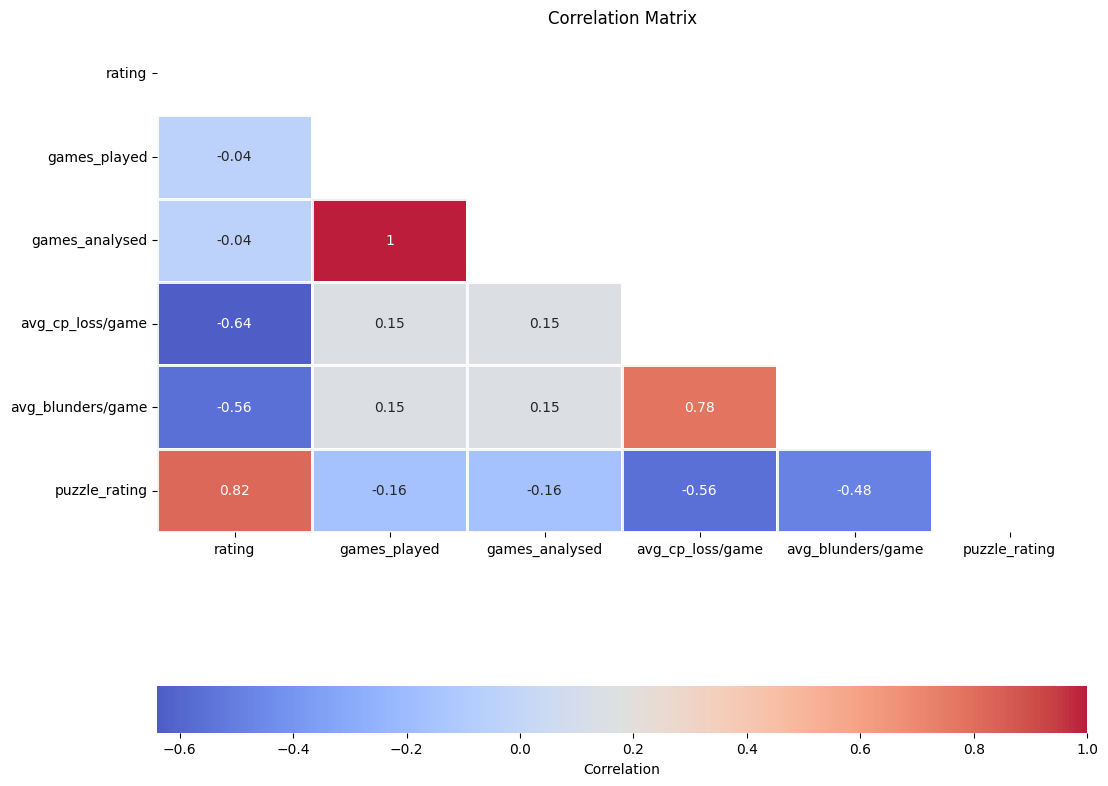

In [59]:
# Create a heatmap using seaborn
mask = np.triu(np.ones_like(round(averages.corr(),2), dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(
    round(averages.corr(),2), 
    annot=True, 
    cmap='coolwarm', 
    linewidths=1, 
    mask=mask, 
    cbar_kws={"orientation": "horizontal", "pad": 0.2, "label": "Correlation"}, 
    alpha=0.9
    )
plt.title('Correlation Matrix')
plt.show()

## Linear Regressions

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2180.870930,71.079315,30.682216,1.252472e-56,0.407847,0.402607,2040.049987,2321.691874
1,avg_cp_loss/game,-9.593726,1.087467,-8.822080,1.608348e-14,0.407847,0.402607,-11.748195,-7.439256


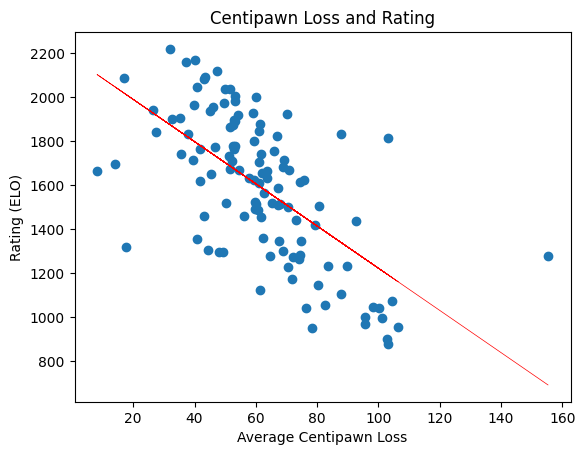

In [60]:
plt.scatter(averages["avg_cp_loss/game"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["avg_cp_loss/game"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]

plt.plot(averages["avg_cp_loss/game"], a*averages["avg_cp_loss/game"]+b, color="red", linewidth=0.5)

plt.title("Centipawn Loss and Rating")
plt.xlabel("Average Centipawn Loss")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,2015.349341,63.984991,31.497220,8.805122e-58,0.317535,0.311495,1888.583534,2142.115149
1,avg_blunders/game,-158.947521,21.920928,-7.250949,5.512026e-11,0.317535,0.311495,-202.376832,-115.518210


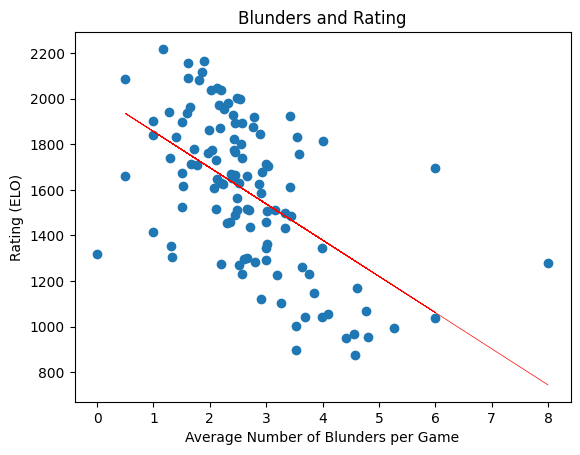

In [26]:
plt.scatter(averages["avg_blunders/game"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["avg_blunders/game"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["avg_blunders/game"], a*averages["avg_blunders/game"]+b, color="red", linewidth=0.5)

plt.title("Blunders and Rating")
plt.xlabel("Average Number of Blunders per Game")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1599.141316,37.745925,42.365932,3.430504e-71,0.001549,-0.007287,1524.359831,1673.922802
1,games_played,-0.029246,0.069850,-0.418695,6.762340e-01,0.001549,-0.007287,-0.167631,0.109139


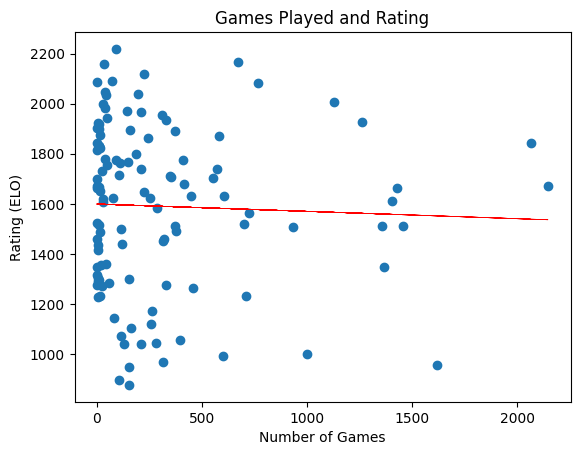

In [27]:
plt.scatter(averages["games_played"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["games_played"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["games_played"], a*averages["games_played"]+b, color="red", linewidth=0.5)

plt.title("Games Played and Rating")
plt.xlabel("Number of Games")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,316.651568,78.269320,4.045667,8.830129e-05,0.6781,0.675661,161.827116,471.476019
1,puzzle_rating,0.748460,0.044884,16.675274,2.711920e-34,0.6781,0.675661,0.659674,0.837246


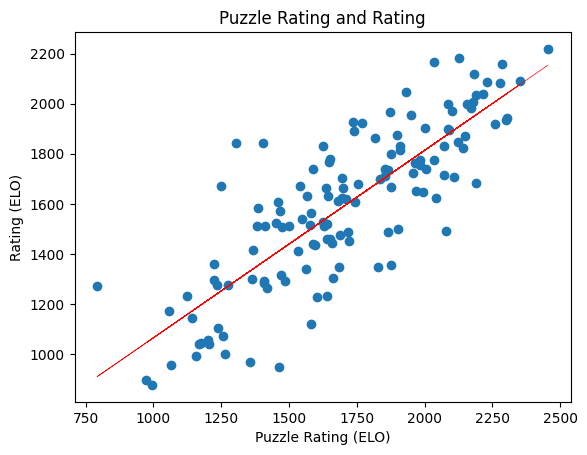

In [28]:
plt.scatter(averages["puzzle_rating"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["puzzle_rating"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["puzzle_rating"], a*averages["puzzle_rating"]+b, color="red", linewidth=0.5)

plt.title("Puzzle Rating and Rating")
plt.xlabel("Puzzle Rating (ELO)")
plt.ylabel("Rating (ELO)")

fit

,names,coef,se,T,pval,r2,adj_r2,CI[2.5%],CI[97.5%]
0,Intercept,1599.141316,37.745925,42.365932,3.430504e-71,0.001549,-0.007287,1524.359831,1673.922802
1,games_analysed,-0.029246,0.069850,-0.418695,6.762340e-01,0.001549,-0.007287,-0.167631,0.109139


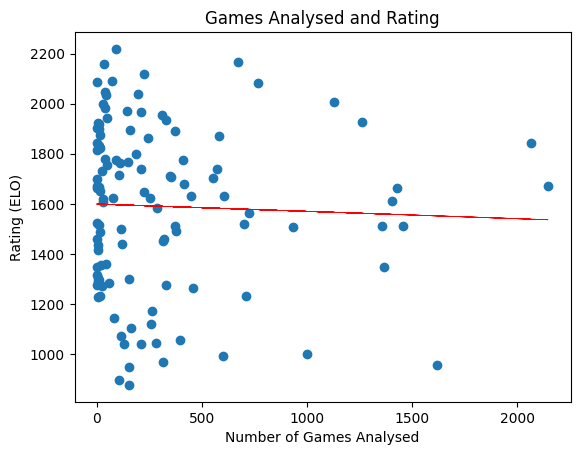

In [29]:
plt.scatter(averages["games_analysed"], averages["rating"])

# linear regression
fit = pg.linear_regression(averages["games_analysed"], averages["rating"], remove_na=True)
a, b = fit.loc[1,"coef"] , fit.loc[0,"coef"]
plt.plot(averages["games_analysed"], a*averages["games_analysed"]+b, color="red", linewidth=0.5)

plt.title("Games Analysed and Rating")
plt.xlabel("Number of Games Analysed")
plt.ylabel("Rating (ELO)")

fit